In [54]:
import os
import gc
import random
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Reshape, multiply, add
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.utils import to_categorical

#### Data Preprocessing Module

- **Purpose**: Load, process, and prepare the dataset for the model, ensuring data quality and consistency.
- **Key Functions**:
  1. **Read Audio Files**: Load audio files from the dataset, converting them to a uniform format if necessary.
   2. **Feature Extraction**: Extract Mel Spectrogram, MFCC (Mel-frequency cepstral coefficients), and Chroma features from audio files to capture frequency, time domain information, and harmonic content.
   3. **Data Visualization**: 
   - Visualize features (e.g., Mel Spectrogram, MFCC, Chroma) to understand the representation and characteristics of the data.
   - Analyze and visualize the dataset distribution, including genre distribution and audio length, to ensure balanced representation and identify potential biases.
   4. **Data Normalization**: Normalize or standardize the Mel Spectrogram data to maintain consistent input scale and distribution for the model.
   5. **Data Splitting**: Divide the dataset into training, validation, and test sets to enable model training, tuning, and evaluation.
   6. **Label Encoding and One-Hot Encoding**: Convert genre labels into a numerical format suitable for model training.

  #### Visualization and Analysis Steps
   - Visualize Mel Spectrogram, MFCC, and Chroma features of random samples.
   - Analyze the distribution of music genres in the dataset.
   - Examine the distribution of audio lengths to understand variability and potential padding/truncation needs.

  #### Data Normalization and Splitting
  - Split the dataset into training, validation, and test sets.
   - Calculate the mean and standard deviation of the training set for normalization.
   - Normalize the training, validation, and test sets to ensure the model receives data in a consistent format.

  #### Output
  - Output the shapes of the training, validation, and test sets to confirm the data structure.

In [25]:
# Load the data
dataset_path = 'C:/Users/xuanl/Desktop/Project/genres'

In [39]:
# Get the features & labels with Mel Spectrogram
def get_features_and_labels(dataset_path, max_pad_len=660, n_mels=128, n_mfcc=13, hop_length=1024, n_fft=4096):
    features_all = []  # Create an empty list for the features
    labels_all = []    # Create an empty list for the labels
    genres = os.listdir(dataset_path)  # Get the list of genres
    
    for genre in genres:
        genre_path = os.path.join(dataset_path, genre)  # Get the path of each genre
        files_sound = os.listdir(genre_path)  # Get the list of songs
        print('Processing %d songs in %s genre...' % (len(files_sound), genre)) 

        for file in files_sound:
            file_path = os.path.join(genre_path, file) # Get the path of each song
            signal, sr = librosa.load(file_path, sr=None) # Load the audio file
            
            # Extract the Mel Spectrogram features
            melspec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft) # Extract Mel Spectrogram
            melspec = librosa.power_to_db(melspec, ref=np.max)  # Convert to log scale (dB)

            # Extract the MFCC features
            mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)

            # Extract the Chroma features
            chroma = librosa.feature.chroma_stft(y=signal, sr=sr, hop_length=hop_length, n_fft=n_fft)

            # Combine features into one array
            combined = np.concatenate((melspec, mfcc, chroma), axis=0)

            # Pad or truncate data
            pad_width = max_pad_len - combined.shape[1] # Get the pad width size
            combined = np.pad(combined, pad_width=((0, 0), (0, pad_width)), mode='constant') # Pad with zeros

            combined = np.expand_dims(combined, -1) # Add the channel dimension
            features_all.append(combined) # Append the features to the list
            labels_all.append(genre) # Append the labels to the list

        # Free up memory
        gc.collect()
            
    # Convert labels to one-hot encoding
    label_encoder = LabelEncoder() # Create a label encoder
    labels_all = label_encoder.fit_transform(labels_all) # Convert the labels to numeric indexes
    labels_all = to_categorical(labels_all) # Convert the labels to one-hot encoding

    return np.array(features_all), np.array(labels_all), label_encoder

features, labels, label_encoder= get_features_and_labels(dataset_path)

Processing 100 songs in blues genre...
Processing 100 songs in classical genre...
Processing 100 songs in country genre...
Processing 100 songs in disco genre...
Processing 100 songs in hiphop genre...
Processing 100 songs in jazz genre...
Processing 100 songs in metal genre...
Processing 100 songs in pop genre...
Processing 100 songs in reggae genre...
Processing 100 songs in rock genre...


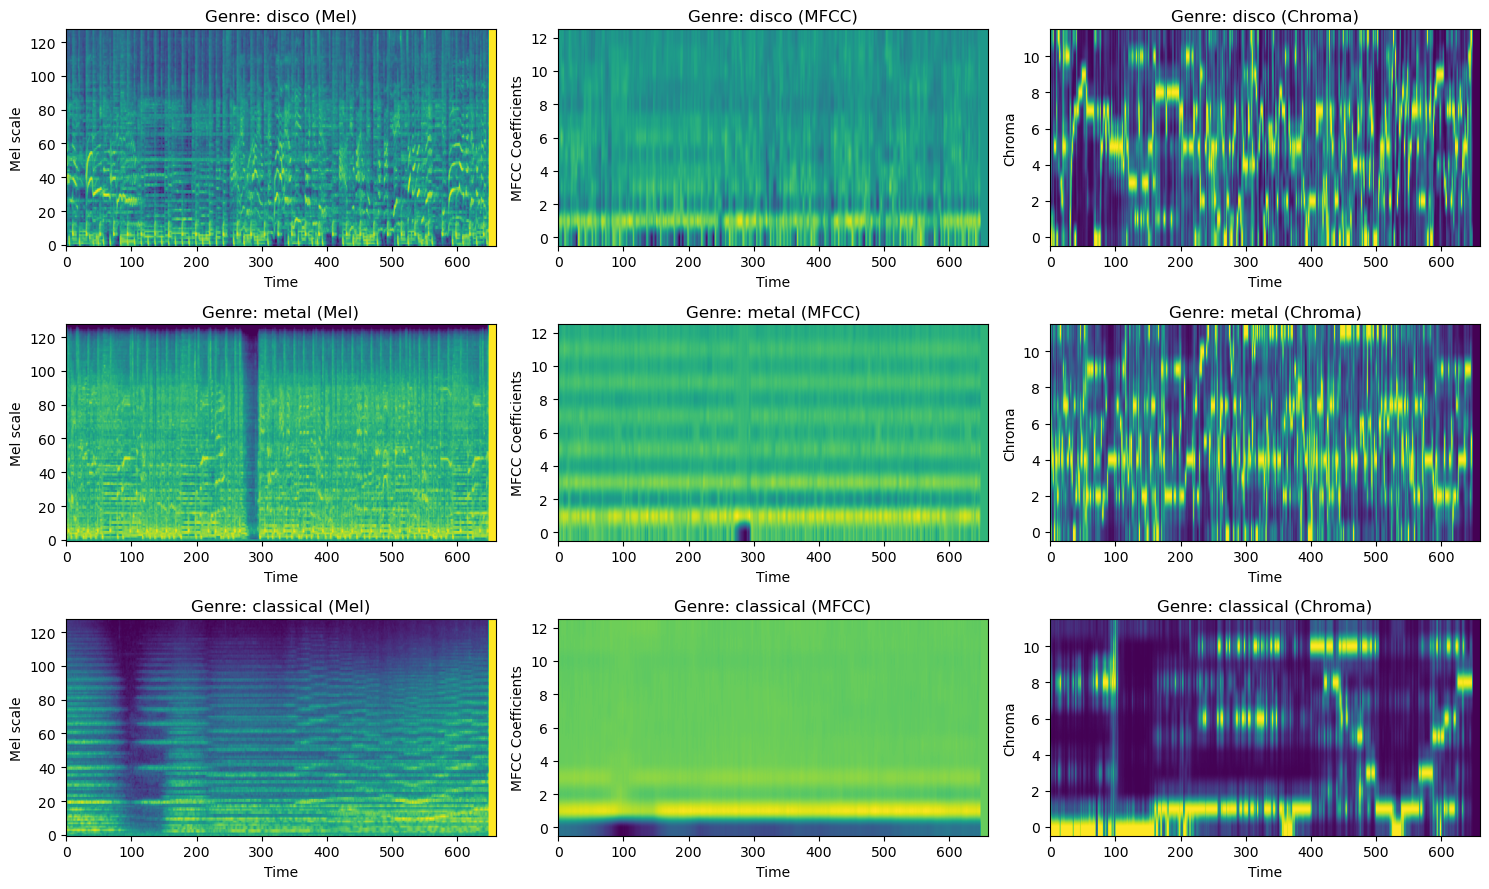

In [42]:
# Visualize the features
def plot_features(features, labels, label_encoder, num_samples=3, n_mels=128, n_mfcc=13, n_chroma=12):
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 3))  # 3 subplots for each sample
    if num_samples == 1:
        axes = [axes]

    for i in range(num_samples):
        index = random.randint(0, len(features) - 1)
        
        # Get Characteristics of Mel Spectrogram, MFCC, and Chroma
        melspec = features[index][:n_mels, :, 0].squeeze()  # Mel Spectrogram
        mfcc_spec = features[index][n_mels:n_mels+n_mfcc, :, 0].squeeze()  # MFCC
        chroma_spec = features[index][n_mels+n_mfcc:n_mels+n_mfcc+n_chroma, :, 0].squeeze()  # Chroma

        genre = label_encoder.inverse_transform([np.argmax(labels[index])])[0]

        # Mel Spectrogram
        axes[i, 0].imshow(melspec, aspect='auto', origin='lower')
        axes[i, 0].set_title(f'Genre: {genre} (Mel)')
        axes[i, 0].set_ylabel('Mel scale')
        axes[i, 0].set_xlabel('Time')

        # MFCC
        axes[i, 1].imshow(mfcc_spec, aspect='auto', origin='lower')
        axes[i, 1].set_title(f'Genre: {genre} (MFCC)')
        axes[i, 1].set_ylabel('MFCC Coefficients')
        axes[i, 1].set_xlabel('Time')

        # Chroma
        axes[i, 2].imshow(chroma_spec, aspect='auto', origin='lower')
        axes[i, 2].set_title(f'Genre: {genre} (Chroma)')
        axes[i, 2].set_ylabel('Chroma')
        axes[i, 2].set_xlabel('Time')

    plt.tight_layout()
    plt.show()
plot_features(features, labels, label_encoder)

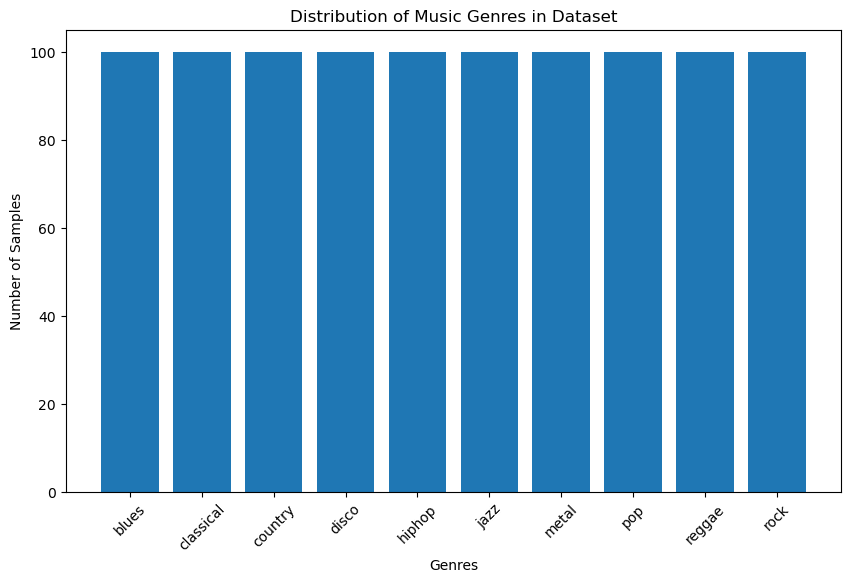

In [43]:
# Visualize the distribution of the genres
def plot_genre_distribution(labels, label_encoder):
    genre_counts = np.sum(labels, axis=0)
    genres = label_encoder.classes_
    plt.figure(figsize=(10, 6))
    plt.bar(genres, genre_counts)
    plt.xlabel('Genres')
    plt.ylabel('Number of Samples')
    plt.title('Distribution of Music Genres in Dataset')
    plt.xticks(rotation=45)
    plt.show()

plot_genre_distribution(labels, label_encoder)

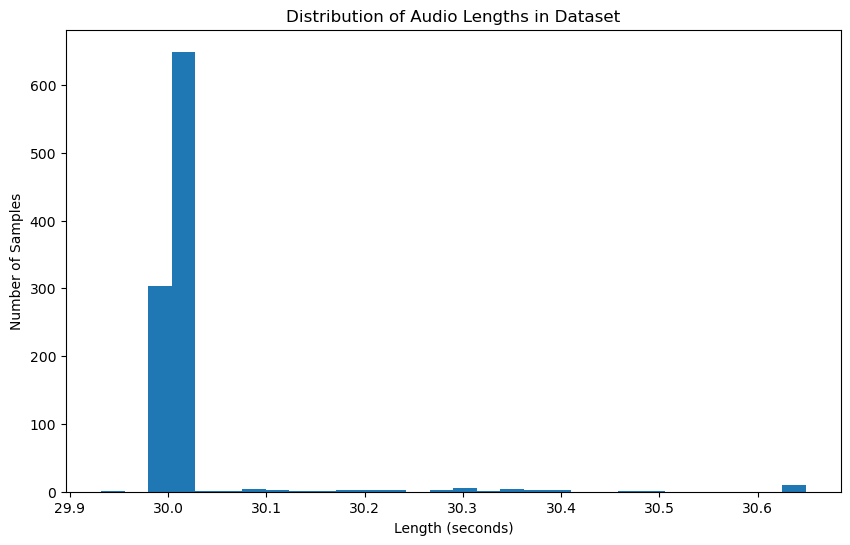

In [29]:
# Check the distribution of audio lengths
def plot_audio_length_distribution(dataset_path):
    lengths = []
    genres = os.listdir(dataset_path)
    for genre in genres:
        genre_path = os.path.join(dataset_path, genre)
        files_sound = os.listdir(genre_path)
        for file in files_sound:
            file_path = os.path.join(genre_path, file)
            signal, sr = librosa.load(file_path, sr=None)
            lengths.append(len(signal) / sr)  # Convert to seconds

    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=30)
    plt.xlabel('Length (seconds)')
    plt.ylabel('Number of Samples')
    plt.title('Distribution of Audio Lengths in Dataset')
    plt.show()

plot_audio_length_distribution(dataset_path)

In [44]:
# Split the data into training, validation, and testing sets

# Split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
# Split the testing data into validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) 

# Calculate the mean and standard deviation of the training set
mean = np.mean(X_train)
std = np.std(X_train)

# Normalize the training, validation, and testing sets
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

# Print the shape of the sets
print('Training set shape: ', X_train.shape)
print('Validation set shape: ', X_val.shape)
print('Testing set shape: ', X_test.shape)

Training set shape:  (700, 153, 660, 1)
Validation set shape:  (150, 153, 660, 1)
Testing set shape:  (150, 153, 660, 1)


#### Model Definition Module

- **Purpose**: Develop and establish the architecture of a hybrid CNN (Convolutional Neural Network) for the classification of music genres, leveraging the strengths of deep learning for audio analysis.
- **Key Functions**:
  1. **CNN Architecture Development**:
   - Construct a series of convolutional layers with different kernel sizes to extract a diverse range of spatial features from Mel Spectrogram inputs.
   - Integrate residual connections within the CNN blocks to promote more effective deep network training, addressing potential issues like vanishing gradients.
   - Enhance feature extraction capabilities through the integration of squeeze-and-excitation blocks, focusing the model's attention on more relevant patterns in the data.
   2. **Normalization and Activation**:
   - Employ Batch Normalization after convolutional layers to stabilize the learning process, ensuring more consistent training performance.
   - Utilize LeakyReLU activation functions for adding non-linearities to the model, mitigating the problem of inactive neurons often seen with ReLU.
   3. **Pooling and Regularization**:
   - Implement MaxPooling layers to reduce dimensionality and induce spatial invariance, capturing essential features while reducing computational load.
   - Include Dropout layers strategically to prevent the model from overfitting, promoting better generalization by randomly deactivating a fraction of neurons during training.
   4. **Dense Layers and Output**:
   - Flatten the CNN outputs to feed into dense (fully connected) layers, culminating in the final classification layer.
   - The final output layer utilizes a softmax activation function, enabling the model to classify input data into multiple genre categories.
   5. **Compilation and Optimization**:
   - Compile the model with a categorical cross-entropy loss function and the Adam optimizer, fine-tuned for effective learning and generalization in multi-class classification tasks.
   - The model's learning rate and other hyperparameters are set to optimize training efficiency and model accuracy.

   #### Model Summary
   - After defining the model, view a summary of the architecture to verify layer configurations, output shapes, and parameter counts.
   - Ensure that the model's structure aligns with the intended design for audio feature extraction and classification.

   #### Model Implementation
   - Execute the model creation function with the specified input shape and number of genre classes.
   - Confirm successful model construction and readiness for training, as indicated by the output message.

In [58]:
# Build the model

# Create a squeeze-and-excitation block
def squeeze_excite_block(input, ratio=16):
    init = input
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', use_bias=False)(se)

    x = multiply([init, se])
    return x

# Create the model
def create_model(input_shape=(153, 660, 1), num_classes=10):
    inputs = Input(shape=input_shape)
    
    # First conv block with residual connection
    x = Conv2D(64, (7, 7), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    x_res = Conv2D(64, (1, 1), padding='same')(inputs)  # 1x1 Conv for residual connection
    x_res = BatchNormalization()(x_res)
    x_res = LeakyReLU()(x_res)
    x_res = MaxPooling2D((2, 2))(x_res)
    x = add([x, x_res])  # Add the residual connection
    x = squeeze_excite_block(x)  # Add the squeeze-and-excitation block

    # Second conv block with residual connection
    x = Conv2D(128, (5, 5), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 4))(x)
    x = Dropout(0.3)(x)
    x_res = Conv2D(128, (1, 1), padding='same')(x_res)  # 1x1 Conv starting from last x_res
    x_res = BatchNormalization()(x_res)
    x_res = LeakyReLU()(x_res)
    x_res = MaxPooling2D((2, 4))(x_res)
    x = add([x, x_res])  # Add the residual connection
    x = squeeze_excite_block(x)  # Add the squeeze-and-excitation block

    # Third conv block with residual connection
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 4))(x)
    x = Dropout(0.4)(x)
    x_res = Conv2D(256, (1, 1), padding='same')(x_res)  # 1x1 Conv starting from last x_res
    x_res = BatchNormalization()(x_res)
    x_res = LeakyReLU()(x_res)
    x_res = MaxPooling2D((2, 4))(x_res)
    x = add([x, x_res])  # Add the residual connection
    x = squeeze_excite_block(x)  # Add the squeeze-and-excitation block

    # Fourth conv block with residual connection
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 4))(x)
    x = Dropout(0.4)(x)
    x_res = Conv2D(512, (1, 1), padding='same')(x_res)  # 1x1 Conv starting from last x_res
    x_res = BatchNormalization()(x_res)
    x_res = LeakyReLU()(x_res)
    x_res = MaxPooling2D((2, 4))(x_res)
    x = add([x, x_res])  # Add the residual connection
    x = squeeze_excite_block(x)  # Add the squeeze-and-excitation block

    # Flatten and fully connected layers
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    # Set the Learning Rate
    learning_rate = 0.0001

    # Compile the model with Adam optimizer
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=learning_rate))
    
    # Compile the model with SGD optimizer
    #model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True))

    # Print the model summary
    model.summary()

    return model

# Create the model
model = create_model(input_shape=(153, 660, 1), num_classes=10)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 153, 660, 1)]        0         []                            
                                                                                                  
 conv2d_86 (Conv2D)          (None, 153, 660, 64)         3200      ['input_16[0][0]']            
                                                                                                  
 batch_normalization_50 (Ba  (None, 153, 660, 64)         256       ['conv2d_86[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_87 (Conv2D)          (None, 153, 660, 64)         128       ['input_16[0][0]']      

#### Training Module

- **Purpose**: Conduct the training process for the music genre classification model using the prepared dataset.
- **Key Functions**:
  1. **Model Training**: Train the model using the training dataset with specified epochs and batch size. Validation data is used for performance evaluation during training.
  2. **Callbacks**:
     - **ModelCheckpoint**: Save the model weights only when there is an improvement in validation loss, ensuring the best model is retained.
     - **EarlyStopping**: Stop training when the validation loss ceases to decrease, preventing overfitting and saving computational resources. Restore the best weights once the training stops.
  3. **Monitoring Performance**: Keep track of training and validation accuracy and loss to understand the learning process and model's performance.
  4. **Visualization**: Plot the accuracy and loss graphs for both training and validation sets to visually analyze the model's learning trends and convergence behavior.

  #### Training Execution and Visualization
  - Execute model training with callbacks for checkpoint saving and early stopping.
  - Plot training and validation accuracy and loss to visualize the model's performance over epochs.

In [59]:
# Create a callback that saves the model's weights
checkpoint = ModelCheckpoint(filepath='music_classification.h5', save_best_only=True, verbose=1, monitor='val_loss', mode='min')
# Create a callback that stops the training when the validation loss does not improve
early_stopping = EarlyStopping(patience=10, verbose=1, monitor='val_loss', mode='min', restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=100,
                    batch_size=16, 
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, early_stopping])

Epoch 1/100
44/44 [==============================] - ETA: 0s - loss: 2.9307 - accuracy: 0.1314
Epoch 1: val_loss improved from inf to 2.29593, saving model to music_classification.h5
44/44 [==============================] - 155s 3s/step - loss: 2.9307 - accuracy: 0.1314 - val_loss: 2.2959 - val_accuracy: 0.1067
Epoch 2/100
44/44 [==============================] - ETA: 0s - loss: 2.2251 - accuracy: 0.1771
Epoch 2: val_loss improved from 2.29593 to 2.28349, saving model to music_classification.h5
44/44 [==============================] - 145s 3s/step - loss: 2.2251 - accuracy: 0.1771 - val_loss: 2.2835 - val_accuracy: 0.1067
Epoch 3/100
44/44 [==============================] - ETA: 0s - loss: 2.2073 - accuracy: 0.2029
Epoch 3: val_loss improved from 2.28349 to 2.27789, saving model to music_classification.h5
44/44 [==============================] - 148s 3s/step - loss: 2.2073 - accuracy: 0.2029 - val_loss: 2.2779 - val_accuracy: 0.1067
Epoch 4/100
44/44 [==============================] - 

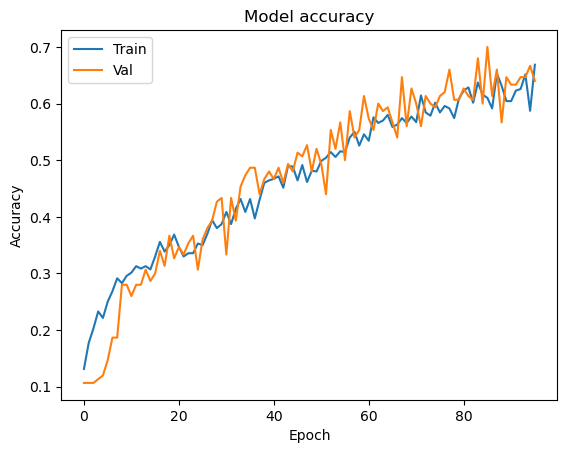

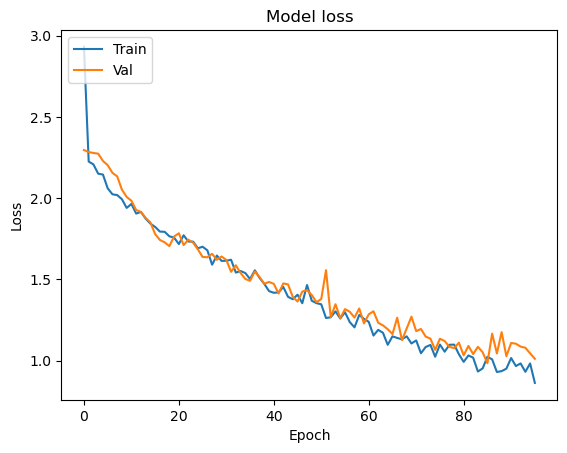

In [60]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

#### Evaluation and Testing Module

- **Purpose**: Assess the trained model's performance on unseen test data to gauge its generalization capabilities and predictive accuracy.
- **Key Functions**:
  1. **Model Loading**: Load the best model based on previously saved weights.
  2. **Performance Evaluation**:
     - Use the test set to evaluate the model, obtaining metrics like loss and accuracy.
     - Generate and analyze a classification report to understand performance across different classes.
  3. **Confusion Matrix**: 
     - Construct and visualize the confusion matrix to analyze the model's classification behavior across various genres.
     - Use the confusion matrix to identify classes that are well-predicted and those where the model may be confusing or misclassifying.
  4. **Predictions**:
     - Generate predictions for the test set.
     - Extract and analyze the predicted classes versus the true classes.

   #### Evaluation Execution
   - Evaluate the model on the test set and print the loss and accuracy.
   - Predict on the test set and analyze the results using a confusion matrix and classification report for a detailed view of the model's performance on each music genre.

5/5 [==============================] - 9s 1s/step - loss: 1.1537 - accuracy: 0.6333
Test Loss: 1.1537222862243652
Test Accuracy: 0.6333333253860474
5/5 [==============================] - 7s 1s/step


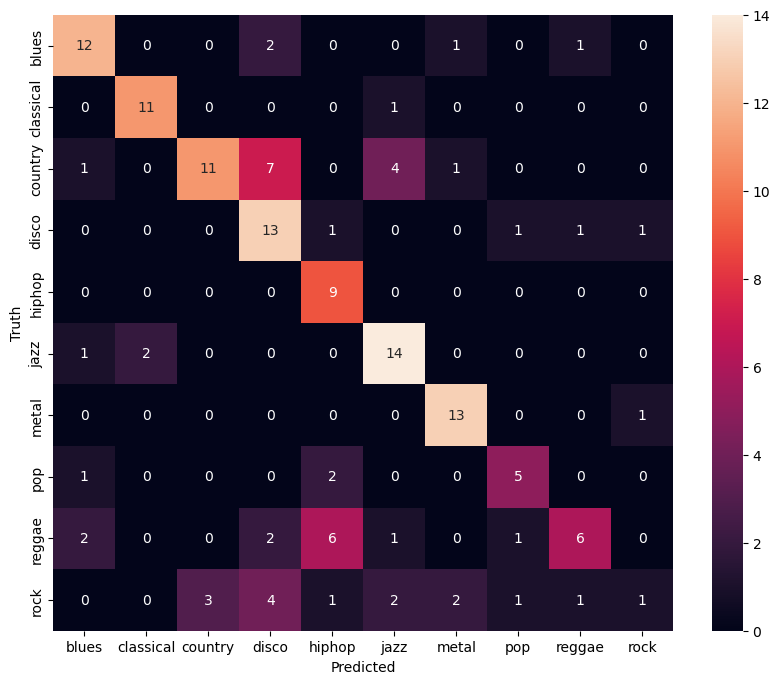

              precision    recall  f1-score   support

           0       0.71      0.75      0.73        16
           1       0.85      0.92      0.88        12
           2       0.79      0.46      0.58        24
           3       0.46      0.76      0.58        17
           4       0.47      1.00      0.64         9
           5       0.64      0.82      0.72        17
           6       0.76      0.93      0.84        14
           7       0.62      0.62      0.62         8
           8       0.67      0.33      0.44        18
           9       0.33      0.07      0.11        15

    accuracy                           0.63       150
   macro avg       0.63      0.67      0.61       150
weighted avg       0.64      0.63      0.60       150



In [61]:
# Load the best model
model = load_model('music_classification.h5')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Get the predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Plot the confusion matrix
#genres_label=['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

#### Prediction and Application Module

- **Purpose**: Utilize the trained and validated model to predict music genres on new samples, effectively applying the model in practical scenarios.
- **Key Functions**:
  1. **Model Saving and Loading**:
     - Save the final trained model for future use, ensuring that the model's state can be reused without retraining.
     - Load the saved model to perform genre classification on new music samples.
  2. **Model Summary and Evaluation**:
     - Review the model's architecture with a summary to understand its layers, parameters, and overall structure.
     - Evaluate the model's performance on the test set, obtaining key metrics such as loss and accuracy, to confirm its effectiveness.
  3. **Predictions and Practical Use**:
     - Deploy the model to classify and predict genres of new music samples, demonstrating its real-world applicability.
     - Utilize the model's predictive capabilities to support tasks like music recommendation, organization, and analysis.

   #### Execution Steps
   - Save the final model and load it for verification.
   - Output the model's detailed architecture and summary.
   - Evaluate the loaded model on the test dataset to ensure consistency and accuracy of predictions.
   - Prepare for applying the model to real-world tasks such as genre classification of new music tracks.

In [62]:
# Save the model
model.save('final_music_genre_model.h5')
print("Model saved successfully as final_music_genre_model.h5")

# Load the model
model = load_model('final_music_genre_model.h5')

# Output the model summary
model.summary()

# Output the model's training and validation loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

d:\Program Data\anaconda3\envs\py5305\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully as final_music_genre_model.h5
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 153, 660, 1)]        0         []                            
                                                                                                  
 conv2d_86 (Conv2D)          (None, 153, 660, 64)         3200      ['input_16[0][0]']            
                                                                                                  
 batch_normalization_50 (Ba  (None, 153, 660, 64)         256       ['conv2d_86[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_87 (Conv2D)          (None, 1